 #  Feedforward Neural Network (Multilayer Perceptron - MLP) 
 Нейронная сеть с прямолинейным движением (многослойный перцептрон - MLP) 

# Блок 1: Импорт библиотек
Этот блок содержит все необходимые импорты библиотек для:

- Работы с данными (numpy, pandas)
- Машинного обучения (tensorflow, sklearn)
- Обработки сигналов (pywt для вейвлет-преобразований)
- Визуализации (seaborn, matplotlib)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pywt
import seaborn as sns
import matplotlib.pyplot as plt

# Блок 2: Загрузка данных и первоначальный осмотр

In [2]:
# 1. Data Loading and Initial Inspection
df = pd.read_csv('final_classification_dataset.csv')
df.head()

,clean_signal,noise_signal,class,clean_signal_strength,noise_signal_strength,clean_interference_type,noise_interference_type
0,[ 0.53289387 0.48063746 0.42904256 0.378523...,[-0.08768768 -0.06199073 -0.03619172 -0.010593...,0,-28,-7,NaN,NaN
1,[ 0.50528564 0.46466091 0.42324726 0.381706...,[ 0.14792691 0.13895541 0.13001185 0.121231...,0,-55,-3,NaN,NaN
2,[-7.18195220e-01 -6.40748815e-01 -5.65319141e-...,[ 0.93549859 0.83830764 0.12244383 0.767919...,1,-8,-22,NaN,Adjacent-channel
3,[-0.96790673 -0.87108426 -0.77470803 -0.679792...,[ 0.50528564 0.46466091 0.42324726 0.381706...,0,-13,-55,NaN,NaN
4,[ 0.98972575 0.9192528 0.84971362 0.781599...,[-0.33507636 -0.88348707 -0.47259825 -0.746120...,1,-40,-99,NaN,Intermodulation


In [3]:
print("типы данных каждого столбца:")
df.dtypes

типы данных каждого столбца:


clean_signal                object
noise_signal                object
class                        int64
clean_signal_strength        int64
noise_signal_strength        int64
clean_interference_type    float64
noise_interference_type     object
dtype: object

In [4]:
print("количество пропущенных значений в каждом столбце:")
df.isnull().sum()

количество пропущенных значений в каждом столбце:


clean_signal                  0
noise_signal                  0
class                         0
clean_signal_strength         0
noise_signal_strength         0
clean_interference_type    2856
noise_interference_type    1551
dtype: int64

# Блок 3: Предварительная обработка данных
-  ненужного столбца 'clean_interference_type'
- Преобразование сигналов из строкового формата в numpy массивы
- Заполнение пропущенных значений в столбце 'noise_interference_type' наиболее частым значением

In [5]:
# 2. Data Preprocessing
def preprocess_data(df):
    # Remove unnecessary columns
    if 'clean_interference_type' in df.columns:
        df = df.drop(columns=['clean_interference_type'])
    
    # Convert signal columns from string to arrays
    def convert_to_array(x):
        if isinstance(x, str):
            return np.fromstring(x.strip('[]'), sep=' ')
        return x
    
    df['clean_signal'] = df['clean_signal'].apply(convert_to_array)
    df['noise_signal'] = df['noise_signal'].apply(convert_to_array)
    
    # Handle missing values in interference type
    if df['noise_interference_type'].dtype == 'object':
        imputer = SimpleImputer(strategy='most_frequent')
        df['noise_interference_type'] = imputer.fit_transform(
            df['noise_interference_type'].values.reshape(-1, 1)).ravel()
    
    return df

df = preprocess_data(df)

# Блок 4: Разведочный анализ данных (EDA)
- Типов помех (визуализирует с помощью столбчатой диаграммы)
- Целевого класса (бинарная классификация)


Interference type distribution:
noise_interference_type
Adjacent-channel    2004
Intermodulation      428
Co-channel           424
Name: count, dtype: int64


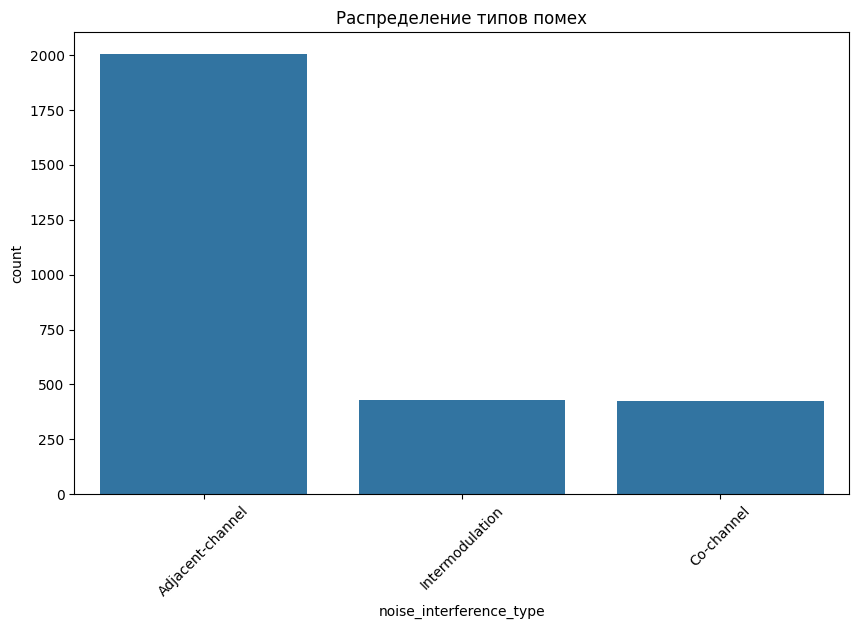


Class distribution:
class
0    1428
1    1428
Name: count, dtype: int64


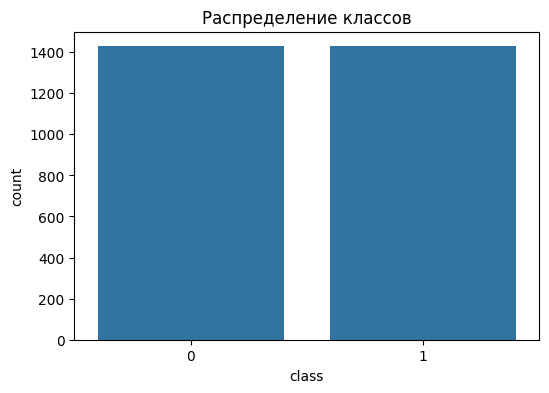

In [6]:
# 3. Exploratory Data Analysis
print("\nInterference type distribution:")
print(df['noise_interference_type'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='noise_interference_type')
plt.title('Распределение типов помех')
plt.xticks(rotation=45)
plt.show()

print("\nClass distribution:")
print(df['class'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='class')
plt.title('Распределение классов')
plt.show()

# Блок 5: Извлечение признаков
Функция extract_features выполняет:
- Приведение сигналов к одинаковой длине
- Вейвлет-преобразование сигналов
- Кодирование категориальных признаков
- Объединение всех признаков в одну матрицу

In [7]:
# 4. Feature Engineering
def extract_features(df, max_len=200, wavelet='db1', level=3):
    # Flatten signals to consistent length
    def flatten_signal(signal, max_len):
        return np.array([np.array(x)[:max_len] if len(x) > max_len else 
                       np.pad(np.array(x), (0, max_len - len(x)), 'constant')
                      for x in signal])
    
    clean_signals = flatten_signal(df['clean_signal'], max_len)
    noise_signals = flatten_signal(df['noise_signal'], max_len)
    
    # Wavelet transform
    def wavelet_transform(signal):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        return np.hstack([c.flatten() for c in coeffs])
    
    wavelet_clean = np.array([wavelet_transform(x) for x in clean_signals])
    wavelet_noise = np.array([wavelet_transform(x) for x in noise_signals])
    
    # Encode categorical features
    encoder = LabelEncoder()
    interference_encoded = encoder.fit_transform(df['noise_interference_type'])
    
    # Combine all features
    features = np.column_stack([
        clean_signals,
        noise_signals,
        wavelet_clean,
        wavelet_noise,
        interference_encoded.reshape(-1, 1),
        df[['clean_signal_strength', 'noise_signal_strength']].values
    ])
    
    return features, df['class'].values, encoder.classes_

X, y, interference_classes = extract_features(df)
print("\Празмер матрицы признаков:", X.shape)

\Празмер матрицы признаков: (2856, 803)


# Блок 6: Разделение данных
Разделение данных на обучающую и тестовую выборки в соотношении 80/20 с сохранением распределения классов (stratify).

In [8]:
# 5. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("\Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

\Размер обучающей выборки: (2284, 803)
Размер тестовой выборки: (572, 803)


# Блок 7: Балансировка классов
Применение SMOTE для устранения дисбаланса классов путем генерации синтетических примеров меньшего класса.

In [9]:
# 6. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nРаспределение по классам после SMOTE:")
print(pd.Series(y_train_res).value_counts())


Распределение по классам после SMOTE:
0    1142
1    1142
Name: count, dtype: int64


# Блок 8: Масштабирование признаков
Стандартизация признаков (приведение к нулевому среднему и единичной дисперсии) с использованием StandardScaler.

In [10]:
# 7. Feature Scaling (after train-test split)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Блок 9: Построение модели
Создание нейронной сети с:
- 3 скрытыми слоями с ReLU активацией
- Dropout для регуляризации
- L2 регуляризацией весов
- Выходным слоем с сигмоидной активацией для бинарной классификации

In [11]:
# 8. Model Building
def build_model(input_shape):
    model = Sequential([
        Dense(128, input_dim=input_shape, activation='relu', 
              kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall(),
                 tf.keras.metrics.AUC()]
    )
    return model

model = build_model(X_train_scaled.shape[1])
print("\nAрхитектура модели с количеством параметров:")
model.summary()


Aрхитектура модели с количеством параметров:


C:\Users\diate\tf_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         102,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,281 (442.50 KB)

 Trainable params: 113,281 (442.50 KB)

 Non-trainable params: 0 (0.00 B)

# Блок 10: Обучение модели
- Обучение модели с:
- Ранней остановкой для предотвращения переобучения
- Разделением на обучение и валидацию
- 30 эпохами (но может остановиться раньше из-за EarlyStopping)

In [12]:
# 9. Model Training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled,
    y_train_res,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/30
58/58 - 3s - 45ms/step - accuracy: 0.7586 - auc: 0.8554 - loss: 2.9263 - precision: 0.7123 - recall: 0.8474 - val_accuracy: 0.9037 - val_auc: 0.9679 - val_loss: 2.0167 - val_precision: 0.9683 - val_recall: 0.8526
Epoch 2/30
58/58 - 0s - 5ms/step - accuracy: 0.9469 - auc: 0.9828 - loss: 1.6113 - precision: 0.9491 - recall: 0.9416 - val_accuracy: 0.9716 - val_auc: 0.9992 - val_loss: 1.2513 - val_precision: 1.0000 - val_recall: 0.9482
Epoch 3/30
58/58 - 0s - 5ms/step - accuracy: 0.9814 - auc: 0.9950 - loss: 1.0746 - precision: 0.9886 - recall: 0.9731 - val_accuracy: 0.9781 - val_auc: 0.9974 - val_loss: 0.8999 - val_precision: 1.0000 - val_recall: 0.9602
Epoch 4/30
58/58 - 0s - 5ms/step - accuracy: 0.9934 - auc: 0.9969 - loss: 0.7674 - precision: 0.9989 - recall: 0.9877 - val_accuracy: 0.9912 - val_auc: 0.9999 - val_loss: 0.6388 - val_precision: 1.0000 - val_recall: 0.9841
Epoch 5/30
58/58 - 0s - 5ms/step - accuracy: 0.9929 - auc: 0.9997 - loss: 0.5709 - precision: 0.9955 - reca

Блок 11: Визуализация обучения
-  точности на обучении и валидации
- График потерь на обучении и валидации

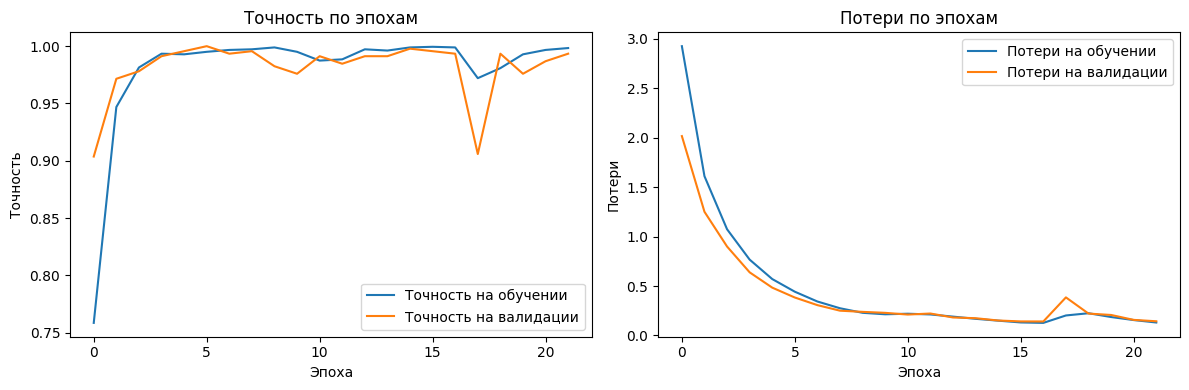

In [13]:
# 10. Model Evaluation
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)  
    plt.plot(history.history['accuracy'], label='Точность на обучении')  
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')  
    plt.title('Точность по эпохам')  
    plt.xlabel('Эпоха')  
    plt.ylabel('Точность')  
    plt.legend()  
  
    plt.subplot(1, 2, 2)  
    plt.plot(history.history['loss'], label='Потери на обучении')  
    plt.plot(history.history['val_loss'], label='Потери на валидации')  
    plt.title('Потери по эпохам')  
    plt.xlabel('Эпоха')  
    plt.ylabel('Потери')  
    plt.legend()  
  
    plt.tight_layout()  
    plt.show()  

plot_training_history(history)

# Блок 12: Оценка модели
Оценка модели на тестовых данных:
- Отчет о классификации с метриками
- Матрица ошибок для визуальной оценки

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Отчёт о классификации:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       286
           1       1.00      0.98      0.99       286

    accuracy                           0.99       572
   macro avg       0.99      0.99      0.99       572
weighted avg       0.99      0.99      0.99       572



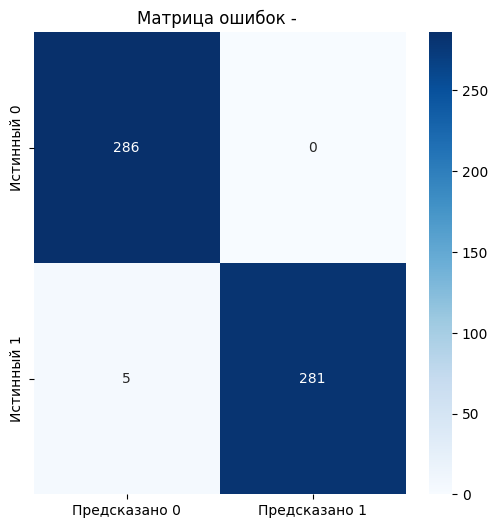

In [14]:
# Предсказания
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Отчёт о классификации
print("\nОтчёт о классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Истинный 0', 'Истинный 1'])
plt.title('Матрица ошибок - ')
plt.show()

# Блок 13: Анализ по типам помех
Анализ точности модели в зависимости от типа помехи.



Точность модели для каждого типа помех:
  interference_type  accuracy
1        Co-channel  1.000000
2   Intermodulation  1.000000
0  Adjacent-channel  0.987685


C:\Users\diate\AppData\Local\Temp\ipykernel_1992\984831484.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interference_performance = performance_df.groupby('interference_type').apply(


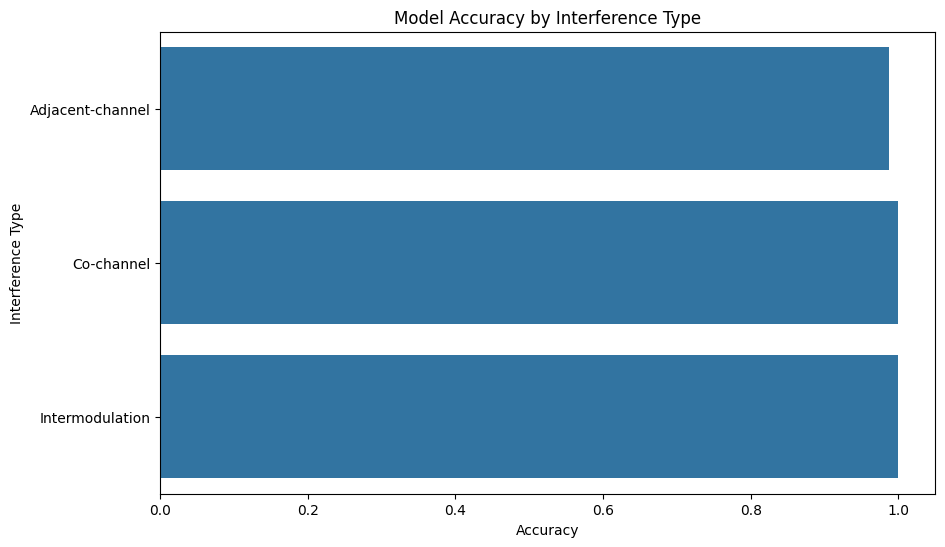

In [15]:
# 11. Interference Type Analysis
def analyze_interference_performance(df, X_test, y_test, y_pred, interference_classes):
    # Get original test indices
    _, test_indices = train_test_split(
        np.arange(len(df)), test_size=0.2, random_state=42, stratify=y)
    
    # Create performance dataframe
    performance_df = pd.DataFrame({
        'true_class': y_test,
        'predicted_class': y_pred.flatten(),
        'interference_type': df.iloc[test_indices]['noise_interference_type'].values
    })
    
    # Calculate accuracy by interference type
    interference_performance = performance_df.groupby('interference_type').apply(
        lambda x: (x['true_class'] == x['predicted_class']).mean()).reset_index()
    interference_performance.columns = ['interference_type', 'accuracy']
    
    print("\nТочность модели для каждого типа помех:")
    print(interference_performance.sort_values('accuracy', ascending=False))
    
    # Plot performance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=interference_performance.sort_values('accuracy'), 
                y='interference_type', x='accuracy')
    plt.title('Model Accuracy by Interference Type')
    plt.xlabel('Accuracy')
    plt.ylabel('Interference Type')
    plt.show()
    
    return performance_df

performance_df = analyze_interference_performance(
    df, X_test, y_test, y_pred, interference_classes)

# Блок 13: Финальные метрики

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [17]:
# 13. Final Model Evaluation Metrics
from sklearn.metrics import roc_auc_score, average_precision_score

print("\nМетрики итоговой оценки::")
print(f"Test Accuracy: {np.mean(y_pred.flatten() == y_test):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")


Метрики итоговой оценки::
Test Accuracy: 0.9913
ROC AUC Score: 1.0000
Average Precision: 1.0000


# Блок 14: Сохранение модели

In [18]:
# 14. Save the Model and Preprocessing Objects
import joblib

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(interference_classes, 'interference_classes.pkl')
model.save('interference_classifier.keras')  # Novo formato Keras V3

print("\nМодель и объекты предварительной обработки успешно сохранены.")


Модель и объекты предварительной обработки успешно сохранены.
